# 1. Factor Engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from tqdm import tqdm
import pandas as pd
import polars as pl
import glob
import os


## 1.1 Feature Generation
### 1.1.1 Book Features
We first processes raw order book data and extracts meaningful features for modeling. The following table is the summary of the feature we generated from the original datasets.


1.  **`wap1/2`**  =$ \frac{\text{ask\_price}_{1/2} \cdot \text{bid\_size}_{1/2} + \text{bid\_price}_{1/2} \cdot \text{ask\_size}_{1/2}}{\text{ask\_size}_{1/2} + \text{bid\_size}_{1/2}}$ 

Weighted Average Price at depth 1/2. This smooths out the impact of individual order prices using size as weight. It approximates the "fair" market price better than simple mid-price. Including wap2 captures more of the limit order book’s shape. 

2. **`bid_size_diff`** = $\text{bid\_size}_1 - \text{bid\_size}_2$                                                                                      

Captures the change in demand depth between level 1 and level 2. Large differences may imply lower resilience in the order book.   

3. **`ask_size_diff`** =$\text{ask\_size}_1-\text{ask\_size}_2$                                                                               

Measures ask-side change. Can signal a lack of liquidity on the sell side or increased selling pressure.                              

4. **`price_spread`** = $ \frac{\text{ask\_price}_1}{\text{bid\_price}_1} - 1$                                                                                

A measure of transaction cost and short-term illiquidity.       

5. **`order_imbalance_1/2`** =$\frac{\text{bid\_size1/2} - \text{ask\_size1/2}}{\text{bid\_size1/2} + \text{ask\_size1/2}}$                                                     

Measures demand-supply pressure at level 1/2. Positive values imply buying pressure, negative values suggest selling pressure.              

6. **`depth_ratio`** = $\frac{\text{bid\_size}_1 + \text{bid\_size}_2}{\text{ask\_size}_1 + \text{ask\_size}_2}$                                             

Compares total buy-side depth to sell-side depth. Values > 1 suggest buy-side dominance.             
                                    
7. **`total_volume`** =$ \text{bid\_size}_1 + \text{bid\_size}_2 + \text{ask\_size}_1 + \text{ask\_size}_2$                                                  

Captures overall liquidity in the limit order book. High volume typically corresponds to tighter spreads and lower volatility.            

8. **`wap_diff`**  =$ \text{wap1} - \text{wap2}$                                                                                                           
Measures how much prices diverge between the top and next levels of the book. Large values may indicate price pressure or volatility. Useful for detecting price trends or pressure. 

9. **`log_return1/2`** = $ \log\left( \frac{\text{wap1/2}_t}{\text{wap1/2}_{t-1}} \right)$                                                                        
Log return of using wap1/2. Used in volatility estimation and price dynamics modeling.                       


In [2]:
def aggregate_interval_book(df: pl.DataFrame, interval=None, interval_length=None) -> pl.DataFrame:
    if interval is not None:
        start = interval * interval_length
        end = (interval + 1) * interval_length

        df_interval = df.filter((pl.col("seconds_in_bucket") >= start) & (
            pl.col("seconds_in_bucket") < end))
    else:
        df_interval = df
    df_agg = df_interval.group_by("time_id").agg(

        # realized_volatility

        (pl.col("log_return1").pow(2).sum()).sqrt().alias("realized_volatility1"),
        (pl.col("log_return2").pow(2).sum()).sqrt().alias("realized_volatility2"),

        # high_low_range
        #(pl.col("wap1").max() / pl.col("wap1").min()).log().alias("high_low_range"),

       # simple means
        
        pl.col("wap_balance").mean().alias("wap_balance_mean"),
        #pl.col("order_imbalance_1").mean().alias("order_imbalance_1_mean"),
        pl.col("order_imbalance_total").mean().alias(
            "order_imbalance_total_mean"),
        pl.col("volume_imbalance").mean().alias("volume_imbalance_mean"),
        pl.col("total_volume").mean().alias("total_volume_mean"),
        pl.col("price_spread").mean().alias("price_spread_mean"),
        
        pl.col("ask_price_spread").mean().alias("ask_price_spread_mean"),
        pl.col("bid_price_spread").mean().alias("bid_price_spread_mean"),
        pl.col("bid_size_diff").mean().alias("bid_size_diff_mean"),
        pl.col("ask_size_diff").mean().alias("ask_size_diff_mean"))

    if interval != None:
        df_agg = df_agg.rename({col: f"{col}_{interval}" if col !=
                               "time_id" else "time_id" for col in df_agg.columns})
    return df_agg

In [3]:
def preprocessor_book(file_path, n_intervals=2, interval_length=300):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)

    # Step 1: Add price-level and liquidity-related features
    df = df.with_columns([
         # wap1/2
        ((pl.col("ask_price1") * pl.col("bid_size1") + pl.col("bid_price1") * pl.col("ask_size1")) /
            (pl.col("ask_size1") + pl.col("bid_size1"))
         ).alias("wap1"),
        ((pl.col("ask_price2") * pl.col("bid_size2") + pl.col("bid_price2") * pl.col("ask_size2")) /
            (pl.col("ask_size2") + pl.col("bid_size2"))
         ).alias("wap2"),
        # bid_size_diff, ask_size_diff
        (pl.col("bid_size1") / pl.col("bid_size2")-1).alias("bid_size_diff"),
        (pl.col("ask_size1") / pl.col("ask_size2")-1).alias("ask_size_diff"),
        # price_spread
        ((pl.col("ask_price1") - pl.col("bid_price1")) /
         ((pl.col("ask_price1") + pl.col("bid_price1")) / 2)
         ).alias("price_spread"),
        (pl.col("ask_price1")-pl.col("ask_price2")).alias("ask_price_spread"),
        (pl.col("bid_price1")-pl.col("bid_price2")).alias("bid_price_spread"),
        # order_imbalance_1, order_imbalance_total
        ((pl.col("bid_size1") - pl.col("ask_size1")) /
         (pl.col("bid_size1") + pl.col("ask_size1"))).alias("order_imbalance_1"),
        ((pl.col("bid_size1") + pl.col("bid_size2") - pl.col("ask_size1") - pl.col("ask_size2")) /
         (pl.col("bid_size1") + pl.col("bid_size2") + pl.col("ask_size1") + pl.col("ask_size2"))).alias("order_imbalance_total"),
        # volume_imbalance
        abs((pl.col("bid_size1")+pl.col("bid_size2")) -
            (pl.col("ask_size1") + pl.col("ask_size2"))).alias("volume_imbalance"),
        # total_volume
        (pl.col("bid_size1")+pl.col("bid_size2")+pl.col("ask_size1") +
         pl.col("ask_size2")).alias("total_volume")
    ])
    # Step 2: Add dynamic (time-based) features
    df = df.sort(["time_id", "seconds_in_bucket"])

    df = df.with_columns([
        abs(pl.col("wap1") - pl.col("wap2")).alias("wap_balance"),
        pl.col("wap1").log().diff().over("time_id").alias("log_return1"),
        pl.col("wap2").log().diff().over("time_id").alias("log_return2"),
    ])

    # Step 3: Drop raw order book columns to reduce storage and redundancy
    df = df.drop([
        "ask_price1", "ask_price2", "ask_size1", "ask_size2",
        "bid_price1", "bid_price2", "bid_size1", "bid_size2"
    ])

    # Rows with null values for log_return1/2 are dropped. These nulls are a result of the `.diff()` operation within the calculation.

    merged_df = None
    #for interval in range(n_intervals):
    df_agg = aggregate_interval_book(df, n_intervals-1, interval_length)
    merged_df = df_agg if merged_df is None else merged_df.join(
        df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_book(df)

    df_feature = df_feature.join(merged_df, on="time_id", how="left")

    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    df_feature = df_feature.drop(["time_id"])

    return df_feature

In [4]:
preprocessor_book('data/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0').head()

realized_volatility1,realized_volatility2,wap_balance_mean,order_imbalance_total_mean,volume_imbalance_mean,total_volume_mean,price_spread_mean,ask_price_spread_mean,bid_price_spread_mean,bid_size_diff_mean,ask_size_diff_mean,realized_volatility1_1,realized_volatility2_1,wap_balance_mean_1,order_imbalance_total_mean_1,volume_imbalance_mean_1,total_volume_mean_1,price_spread_mean_1,ask_price_spread_mean_1,bid_price_spread_mean_1,bid_size_diff_mean_1,ask_size_diff_mean_1,row_id
f64,f64,f64,f64,f64,f64,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f64,f64,str
0.004499,0.006999,0.000388,0.013154,134.89404,323.496689,0.000852,-0.000151,0.000176,16.636539,5.060817,0.002953,0.004863,0.000372,0.007668,137.158273,294.928058,0.000822,-0.000162,0.000223,15.558786,6.745682,"""0-5"""
0.001204,0.002476,0.000212,0.177003,142.05,411.45,0.000394,-0.000135,0.000142,5.505701,2.40392,0.000981,0.002009,0.000239,0.21195,135.513043,484.521739,0.000353,-0.000123,0.000164,6.142346,3.657408,"""0-11"""
0.002369,0.004801,0.000331,0.030383,141.414894,416.351064,0.000725,-0.000198,0.000197,7.719648,17.207534,0.001295,0.003196,0.000431,-0.198453,144.147059,455.235294,0.000689,-0.000249,0.000141,13.915022,10.360756,"""0-16"""
0.002574,0.003637,0.00038,-0.119307,146.216667,435.266667,0.00086,-0.000108,0.00019,14.335634,0.559525,0.001776,0.002713,0.000331,-0.030209,144.698113,418.169811,0.000833,-0.000095,0.000158,13.451702,0.778539,"""0-31"""
0.001894,0.003257,0.000254,0.271247,123.846591,343.221591,0.000397,-0.000109,0.000191,23.38884,11.786563,0.00152,0.002188,0.000252,0.144587,99.449438,407.58427,0.000425,-0.00012,0.000191,23.676093,18.207874,"""0-62"""


### 1.1.2 10-Minute Time Window Book Features
This code performs 10min-time-interval aggregation on order book data. It groups data by time_id within specified time intervals and computes key features such as realized volatility, logarithmic price range, and various mean values related to prices, order imbalances, and volume. The aggregated features are then saved as Parquet files named by stock ID, enabling efficient downstream analysis and modeling. 

### 1.1.3 150-Second Time Segment Book Features
This code processes order book data by dividing each trading period into fixed-length intervals (in this case, 4 intervals of 150 seconds each). For each stock file, it aggregates features separately for each time interval using the aggregate_interval_book function, and then merges these interval-based feature sets into a single DataFrame keyed by time_id. The resulting combined features capture finer-grained temporal dynamics within the trading period. Finally, the aggregated data is saved as Parquet files organized by stock ID.

### 1.1.4 Trade Features 
This code processes trade data for stocks, computing additional features such as average trade size per order and the logarithmic return of trade prices. The logarithmic return is calculated as the log of the ratio between the current price and the previous price. Rows with null values resulting from this calculation (due to missing previous prices) are removed to ensure data quality. The cleaned and enriched DataFrame is then saved as Parquet files, organized by stock ID.

### 1.1.5 10-Minute Time Window Trade Features
This code aggregates trade data into 10-minute intervals by grouping on time_id. For each interval, it calculates various statistical features, including realized volatility from squared log returns, price range, mean price, mean order size, total traded size, and standard deviation of trade sizes. The processed features are saved to separate Parquet files for each stock, enabling efficient downstream analysis.

In [5]:
def aggregate_interval_trade(df: pl.DataFrame, interval=None, interval_length=None) -> pl.DataFrame:
    if interval:
        start = interval * interval_length
        end = (interval + 1) * interval_length

        df_interval = df.filter((pl.col("seconds_in_bucket") >= start) & (
            pl.col("seconds_in_bucket") < end))
    else:
        df_interval = df
    df_agg = df_interval.group_by("time_id").agg(


        # trade_realized_volatility
        (pl.col("trade_log_return").pow(2).sum()).sqrt().alias(
            "trade_realized_volatility"),

        # trade_price_range
        #(pl.col("price").max() / pl.col("price").min()).log().alias("trade_price_range"),

        # means

        pl.col("size_per_order").mean().alias("size_per_order_mean"),
        pl.col("order_count").mean().alias("order_count_mean"),

        # sums
        
        pl.col("order_count").sum().alias("total_order"),
        pl.col("seconds_in_bucket").n_unique().alias("trade_time"),
        # std
        pl.col("size").std().alias("size_std"))
    if interval != None:
        df_agg = df_agg.rename({col: f"{col}_{interval}" if col !=
                               "time_id" else "time_id" for col in df_agg.columns})
    return df_agg

In [6]:

def preprocessor_trade(file_path, n_intervals=2, interval_length=300):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)
    df = df.sort(["time_id", "seconds_in_bucket"])

    df = df.with_columns([
        # size_per_order
        (pl.col("size")/pl.col("order_count")).alias("size_per_order"),
        # trade_log_return
         (pl.col("price").diff().over("time_id")).alias("trade_log_return")
    ])

    merged_df = None
    #for interval in range(n_intervals):
        
    df_agg = aggregate_interval_trade(df, n_intervals-1, interval_length)
    merged_df = df_agg if merged_df is None else merged_df.join(df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_trade(df)  

    df_feature = df_feature.join(merged_df, on="time_id", how="left")


    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" + pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    df_feature = df_feature.drop(["time_id"])

    return df_feature

In [7]:
preprocessor_trade('data/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0').head()

trade_realized_volatility,size_per_order_mean,order_count_mean,total_order,trade_time,size_std,trade_realized_volatility_1,size_per_order_mean_1,order_count_mean_1,total_order_1,trade_time_1,size_std_1,row_id
f32,f64,f64,i64,u32,f64,f32,f64,f64,i64,u32,f64,str
0.002013,23.118036,2.75,110,40,118.375107,0.001313,18.628798,2.571429,54,21,141.675888,"""0-5"""
0.000901,20.061111,1.9,57,30,77.815203,0.000588,26.822917,2.25,36,16,90.504144,"""0-11"""
0.00196,25.548476,2.72,68,25,113.587,0.001135,27.236111,3.166667,38,12,130.679663,"""0-16"""
0.001559,33.507407,3.933333,59,15,144.828569,0.001088,34.623457,5.111111,46,9,167.747909,"""0-31"""
0.000871,16.177243,4.045455,89,22,117.914682,0.000453,19.656506,4.909091,54,11,140.061285,"""0-62"""


In [8]:
def preprocessor(list_book_files, list_trade_files, target_data, train=True)->pd.DataFrame:
    dfs = []
    for book_file, trade_file in tqdm(zip(list_book_files, list_trade_files)):
        df_book = preprocessor_book(book_file)
        df_trade = preprocessor_trade(trade_file)
        df_tmp = df_book.join(df_trade, on="row_id", how="left")

        dfs.append(df_tmp)
    df = pl.concat(dfs)
    target_data = target_data.with_columns(
        (pl.col("stock_id").cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    if train:
        target_data = target_data.select([
            "row_id",
            "target"
        ])
    else:
        target_data = target_data.select([
            "row_id",

        ])
    df = df.with_columns(
pl.col("row_id").str.split("-").list.get(0).cast(pl.Int64).alias("stock_id")
)

    df = target_data.join(df, on="row_id", how="left")

    return df.to_pandas()

### Training data preprocess

In [9]:
list_book_train = glob.glob(
    'data/optiver-realized-volatility-prediction/book_train.parquet/*')
list_trade_train = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_train.parquet/*')
train_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/train.csv')

df_train = preprocessor(list_book_train, list_trade_train,train_data)
df_train.head()

0it [00:00, ?it/s]

112it [00:26,  4.20it/s]


,row_id,target,realized_volatility1,realized_volatility2,wap_balance_mean,order_imbalance_total_mean,volume_imbalance_mean,total_volume_mean,price_spread_mean,ask_price_spread_mean,...,total_order,trade_time,size_std,trade_realized_volatility_1,size_per_order_mean_1,order_count_mean_1,total_order_1,trade_time_1,size_std_1,stock_id
0,0-5,0.004136,0.004499,0.006999,0.000388,0.013154,134.894040,323.496689,0.000852,-0.000151,...,110.0,40.0,118.375107,0.001313,18.628798,2.571429,54.0,21.0,141.675888,0
1,0-11,0.001445,0.001204,0.002476,0.000212,0.177003,142.050000,411.450000,0.000394,-0.000135,...,57.0,30.0,77.815203,0.000588,26.822917,2.250000,36.0,16.0,90.504144,0
2,0-16,0.002168,0.002369,0.004801,0.000331,0.030383,141.414894,416.351064,0.000725,-0.000198,...,68.0,25.0,113.587000,0.001135,27.236111,3.166667,38.0,12.0,130.679663,0
3,0-31,0.002195,0.002574,0.003637,0.000380,-0.119307,146.216667,435.266667,0.000860,-0.000108,...,59.0,15.0,144.828569,0.001088,34.623457,5.111111,46.0,9.0,167.747909,0
4,0-62,0.001747,0.001894,0.003257,0.000254,0.271247,123.846591,343.221591,0.000397,-0.000109,...,89.0,22.0,117.914682,0.000453,19.656506,4.909091,54.0,11.0,140.061285,0


### Test data preprocess


In [10]:
list_book_test= glob.glob(
    'data/optiver-realized-volatility-prediction/book_test.parquet/*')
list_trade_test = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_test.parquet/*')
test_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/test.csv')

In [11]:
df_test = preprocessor(list_book_test,list_trade_test,test_data,train=False)

df_test.head()

1it [00:00, 102.70it/s]


,row_id,realized_volatility1,realized_volatility2,wap_balance_mean,order_imbalance_total_mean,volume_imbalance_mean,total_volume_mean,price_spread_mean,ask_price_spread_mean,bid_price_spread_mean,...,total_order,trade_time,size_std,trade_realized_volatility_1,size_per_order_mean_1,order_count_mean_1,total_order_1,trade_time_1,size_std_1,stock_id
0,0-4,0.000294,0.000252,0.000145,0.425558,164.666667,350.666667,0.000557,-0.000115,0.000393,...,11.0,3.0,57.157677,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2.Model Training

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb

import torch

In [13]:
def rmspe(y_true, y_pred):
    # Root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()



def rmspe_feval(y_pred, dataset):
    y_true = dataset.get_label()

    return 'RMSPE', round(rmspe(y_true = y_true, y_pred = y_pred),5), False

In [14]:
stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

In [15]:
kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

categorical_features = X.columns
fold_scores = []
feature_importances = pd.DataFrame()


In [28]:
X.head()

,realized_volatility1,realized_volatility2,wap_balance_mean,order_imbalance_total_mean,volume_imbalance_mean,total_volume_mean,price_spread_mean,ask_price_spread_mean,bid_price_spread_mean,bid_size_diff_mean,...,trade_time,size_std,trade_realized_volatility_1,size_per_order_mean_1,order_count_mean_1,total_order_1,trade_time_1,size_std_1,stock_id,stock_id_target_enc
0,0.004499,0.006999,0.000388,0.013154,134.894040,323.496689,0.000852,-0.000151,0.000176,16.636539,...,40.0,118.375107,0.001313,18.628798,2.571429,54.0,21.0,141.675888,0,0.004041
1,0.001204,0.002476,0.000212,0.177003,142.050000,411.450000,0.000394,-0.000135,0.000142,5.505701,...,30.0,77.815203,0.000588,26.822917,2.250000,36.0,16.0,90.504144,0,0.004039
2,0.002369,0.004801,0.000331,0.030383,141.414894,416.351064,0.000725,-0.000198,0.000197,7.719648,...,25.0,113.587000,0.001135,27.236111,3.166667,38.0,12.0,130.679663,0,0.004041
3,0.002574,0.003637,0.000380,-0.119307,146.216667,435.266667,0.000860,-0.000108,0.000190,14.335634,...,15.0,144.828569,0.001088,34.623457,5.111111,46.0,9.0,167.747909,0,0.004013
4,0.001894,0.003257,0.000254,0.271247,123.846591,343.221591,0.000397,-0.000109,0.000191,23.388840,...,22.0,117.914682,0.000453,19.656506,4.909091,54.0,11.0,140.061285,0,0.004032


In [80]:
params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      #'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }
'''params = {
    "boosting_type": "gbdt",
    "objective": "rmse",
    "metric": ["rmse", "rmspe"],
    "alpha": 0.9,

    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 20,

    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l1": 0.01,
    "lambda_l2": 0.01,
    "drop_rate": 0.1,


}'''

X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
              # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgb.Dataset(X_train,y_train,categorical_feature = ['stock_id'],weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgb.Dataset(X_valid,y_valid    ,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgb.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=rmspe_feval,
                                   callbacks=[ lgb.log_evaluation(100)],
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)

Fold : 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9036
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 36
[LightGBM] [Info] Start training from score 0.001800
[100]	training's rmse: 0.000659482	training's RMSPE: 0.3052	valid_1's rmse: 0.000661789	valid_1's RMSPE: 0.30634
[200]	training's rmse: 0.000535399	training's RMSPE: 0.24778	valid_1's rmse: 0.000540479	valid_1's RMSPE: 0.25019
[300]	training's rmse: 0.000508967	training's RMSPE: 0.23555	valid_1's rmse: 0.000515459	valid_1's RMSPE: 0.2386
[400]	training's rmse: 0.000500905	training's RMSPE: 0.23181	valid_1's rmse: 0.000508637	valid_1's RMSPE: 0.23545
[500]	training's rmse: 0.000496674	training's RMSPE: 0.22986	valid_1's rmse: 0.000505553	valid_1's RMSPE: 0.23402
[600]	training's rmse: 0.000493834	training's RMSPE: 0.22854	valid_1's rmse: 0.0

KeyboardInterrupt: 

In [86]:
params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",

      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

for fold, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
    print(f"Fold {fold+1}")
    
    
    
    X_train, y_train = X.loc[train_idx], y[train_idx]
    X_val, y_val = X.loc[val_idx], y[val_idx]
   

    weights_train = 1 / np.square(y_train.values)
    weights_val = 1 / np.square(y_val.values)

    lgb_train = lgb.Dataset(X_train, label=y_train, weight=weights_train,
                            categorical_feature=['stock_id'])
    lgb_val = lgb.Dataset(X_val, label=y_val, weight=weights_val,
                          reference=lgb_train)
    model = lgb.train(
        params=params,
        train_set=lgb_train,
        num_boost_round=5000,
        feval=rmspe_feval,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(100)],

    )# lgb.early_stopping(stopping_rounds=50)

       
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    rmse = round(rmspe(y_true=y_val, y_pred=y_pred), 3)
    print(f"Fold {fold+1} RMSE: {rmse:.5f}")

    fold_scores.append(rmse)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_train.columns
    fold_importance["importance"] = model.feature_importance(
        importance_type='split')
    fold_importance["fold"] = fold + 1

    feature_importances = pd.concat(
        [feature_importances, fold_importance], axis=0)

print(f"Average RMSE: {np.mean(fold_scores):.5f}")

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9036
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 36
[LightGBM] [Info] Start training from score 0.001797
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000659922	training's RMSPE: 0.30566	valid_1's rmse: 0.000668181	valid_1's RMSPE: 0.30826
[200]	training's rmse: 0.000535948	training's RMSPE: 0.24824	valid_1's rmse: 0.000551888	valid_1's RMSPE: 0.25461
[300]	training's rmse: 0.000509438	training's RMSPE: 0.23596	valid_1's rmse: 0.000528638	valid_1's RMSPE: 0.24388
[400]	training's rmse: 0.000501402	training's RMSPE: 0.23224	valid_1's rmse: 0.000523405	valid_1's RMSPE: 0.24147
[500]	training's rmse: 0.000497135	training's RMSPE: 0.23026	valid_1'

In [87]:
print(f"Average RMSE: {np.mean(fold_scores[-5:]):.5f}")

Average RMSE: 0.23420


## Feature importance

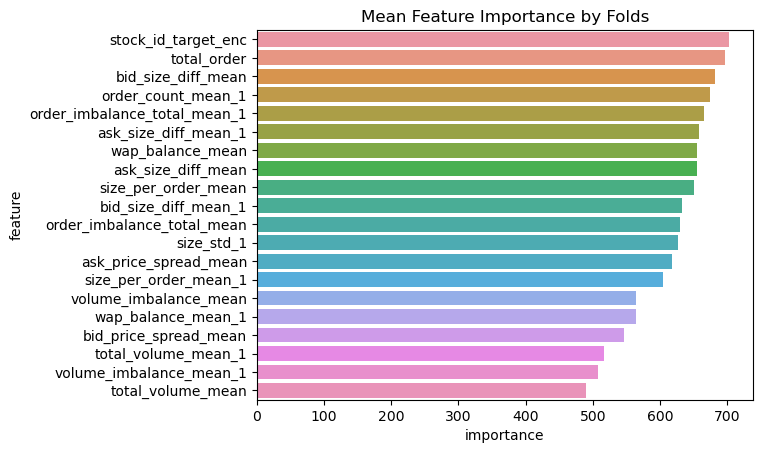

In [88]:
mean_importance = feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)


sns.barplot(x=mean_importance[-20:],
    y=mean_importance.index[-20:])
plt.title('Mean Feature Importance by Folds')
plt.show()

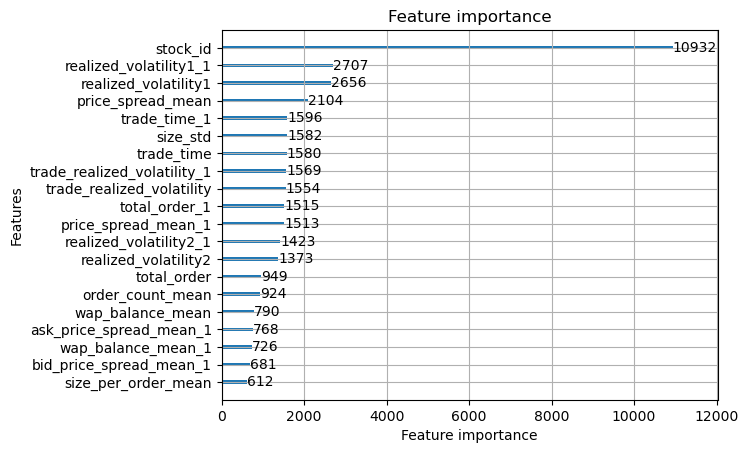

Feature importance (top 20):
total_order_1 6462.803146719933
size_per_order_mean_1 6095.640582740307
stock_id_target_enc 5984.617266654968
total_volume_mean 5612.528221845627
wap_balance_mean 5483.55112606287
order_count_mean 4924.31869083643
wap_balance_mean_1 4127.3595468997955
bid_price_spread_mean 3549.5307598114014
ask_price_spread_mean_1 3056.6721964478493
total_order 2502.1176015138626
volume_imbalance_mean_1 2482.019775032997
bid_price_spread_mean_1 2167.71610891819
total_volume_mean_1 1947.4984058141708
bid_size_diff_mean_1 1385.7209019064903
order_count_mean_1 1203.7024129629135
bid_size_diff_mean 1157.8570733070374
ask_size_diff_mean 1092.2832079529762
order_imbalance_total_mean 945.9696810245514
order_imbalance_total_mean_1 871.1687976121902
ask_size_diff_mean_1 754.7120608687401


In [89]:
lgb.plot_importance(model, max_num_features=20)
plt.show()

# 查看每个特征的重要性分数
importance = model.feature_importance(importance_type='gain')
features = X_train.columns
imp_df = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
print("Feature importance (top 20):")
for f, imp in imp_df[-20:]:
    print(f, imp)
